### Equations

${1.}$ ${M_{fc} = \{U_{c×N} | u_{ik} \in [0, 1];{\;} \sum_{i=1}^{N}u_{ik} \gt0\;}$ for all ${i,\;}$ ${\sum_{i=1}^{N}u_{ik} =1\;}$ for all ${k\}}$
<br><br>
${2.}$ ${J_{m}(U, v) = \sum_{k=1}^{N} \sum_{i=1}^{c} (u_{ik})^{m}||x_{k} - v_{i}||^{2}_{A}}$
<br><br>
${3.}$ ${v_{i} = \sum_{k=1}^{N}{(u_{ik})^{m}}x_{k} / \sum_{k=1}^{N}{(u_{ik})^{m}}}$; ${\;}$ ${1\leqslant i\leqslant c}$
<br><br>
${4.}$ ${u_{ik} = (\sum_{j=1}^{c}{(\frac{d_{ik}}{d_{jk}})^{2/(m-1)}})^{-1}}$; ${\;}$ ${1\leqslant k\leqslant N}$,${\;}$ ${1\leqslant i\leqslant c}$
<br><br>
${5.}$ ${F_{c}(U)=}$ ${\sum_{k=1}^{N} \sum_{i=1}^{c}(u_{ik})^{2}/N}$
<br><br>
${6.}$ ${H_{c}(U)=}$ ${-\sum_{k=1}^{N} \sum_{i=1}^{c}(u_{ik}log_{a}(u_{ik}))/N}$; ${\; a \in (1, \infty)}$

### Variables

${X =}$ {${x_{1}, x_{2},\;...,\;x_{N}}$} ${\subset}$ ${R^{n}}$ ${=}$ the data;
<br>
${x_{k} = }$ the ${k}$-th feature vector;
<br>
${x_{kj} = }$ the ${j}$-th feature of ${x_{k}}$;
<br><br>
${c = }$ number of clusters in ${X}$, ${\;}$ ${2\leqslant c<n}$;
<br>
${m = }$ weighting exponent, ${\;}$ ${2\leqslant m<\infty}$;
<br>
${U = }$ a real ${c × N}$ matrix, ${\;}$ fuzzy c-partition of ${X}$;
<br>
${v = (v_{1}, v_{2}, \;...,\;v_{c})}$ ${=}$ vectors of centers;
<br>
${v_{i} = (v_{i1}, v_{i2}, \;...,\;v_{in})}$ ${=}$ center of cluster ${i}$;
<br><br>
${||\;\;||_{A} = }$ induced ${A}$-norm on ${R^{n}}$;
<br>
${A =}$ positive-definite ${(n × n)}$ weight matrix

### Algorithm

${1.}$ Fix ${c, m, A}$
<br>
${2.}$ Choose an initial matrix ${U^{(0)}\in M_{fc}}$
<br>
${3.}$ Compute means ${v^{(k)}, i=1,\;2,\;...,\;c}$ with equation 3
<br>
${4.}$ Compute an updated membership matrix ${U^{(k+1)} = [u_{ik}^{(k+1)}]}$  with equation 4
<br>
${5.}$ Compare ${U^{(k+1)}}$ to ${U^{(k)}}$ in any convenient matrix norm. If ${||U^{(k+1)} - U^{(k)}|| \lt error}$, stop. Otherwise, set ${ U^{(k)} =  U^{(k+1)}}$ and return to 3

### Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
import os
import errno

from sklearn.metrics import rand_score

from typing import Optional
from pydantic import BaseModel, Extra, Field, validate_arguments

In [17]:
class FCM(BaseModel):
    
    # Step 1
    n_clusters: int = Field(5, ge=1, le=100)
    m: float = Field(2.0, ge=1.0)
    max_iter: int = Field(150, ge=1, le=1000)
    error: float = Field(1e-5, ge=1e-9)
    random_state: Optional[int] = None
    trained: bool = Field(False, const=True)

    class Config:
        extra = Extra.allow
        arbitrary_types_allowed = True

    @validate_arguments
    def fit(self, X):
        n_samples = X.shape[0]
                
        # Construct a random number generator
        self.rng = np.random.default_rng(self.random_state)
        
        # Step 2
        # Initialize u randomly
        # Draw samples from a uniform distribution
        # Samples are uniformly distributed over the interval [0.0, 1.0)
        # (Equation1) is not satisfied here yet, raw sum of u is not equal to 1
        # Example for a sample with two clusters:
        # [.2, .3] -> .2 + .3 = .5 != 1
        self.u = self.rng.uniform(size=(n_samples, self.n_clusters))
        
        # Row sum of u must be equal to 1, based on (Equation1)
        # Each row shows membership (u) of different clusters for a sample
        # Example for a sample with two clusters:
        # [.2, .3] -> [.2/(.2+.3), .3/(.2+.3)] -> [.2/.5, .3/.5] -> [.4, .6] -> .4 + .6 = 1
        self.u = self.u / np.tile(self.u.sum(axis=1)[np.newaxis].T, self.n_clusters)
                        
        # While ||u(i+1) - u(i)|| >= error, update centers and u
        # || || is Euclidean Norm here
        for _ in range(self.max_iter):
            u_old = self.u.copy()
            
            # Step 3
            # Calculate centers using (Equation 3)
            self._centers = FCM._next_centers(X, self.u, self.m)
            
            # Step 4
            # Update U using (Equation 4)
            self.u = self.soft_predict(X)
                        
            # Step 5
            # Stopping rule
            if np.linalg.norm(self.u - u_old) < self.error:
                break

        self.trained = True

    def soft_predict(self, X):
        
        # Calculate the distance of 3 samples and 2 clusters, raise all distances to power 2/(m-1)
        # [[d11=d11^(2/(m-1)), d12=d12^(2/(m-1))],
        #  [d21=d21^(2/(m-1)), d22=d22^(2/(m-1))],
        #  [d31=d31^(2/(m-1)), d32=d32^(2/(m-1))]]
        temp = FCM._dist(X, self._centers) ** float(2 / (self.m - 1))
        
        # Expansion of (Equation 4) for i=2, j=2 (2 clusters), and k=3 (3 samples) is:
        # [[1/(d11/d11+d12/d11), 1/(d11/d12+d12/d12)],
        #  [1/(d21/d21+d22/d21), 1/(d21/d22+d22/d22)],
        #  [1/(d31/d31+d32/d31), 1/(d31/d32+d32/d32)]]
        
        # [[[d11, d12],
        #   [d11, d12]],   
        #  [[d21, d22],
        #   [d21, d22]], 
        #  [[d31, d32],
        #   [d31, d32]]]
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        
        # [[[d11],
        #   [d12]],   
        #  [[d21],
        #   [d22]], 
        #  [[d31],
        #   [d32]]]
        temp = temp[:, :, np.newaxis]
        
        # [[[d11/d11, d12/d11],
        #   [d11/d12, d12/d12]],   
        #  [[d21/d21, d22/d21],
        #   [d21/d22, d22/d22]], 
        #  [[d31/d31, d32/d31],
        #   [d31/d32, d32/d32]]]
        denominator_ = temp / denominator_
        
        # [[d11/d11+d12/d11, d11/d12+d12/d12],
        #  [d21/d21+d22/d21, d21/d22+d22/d22],
        #  [d31/d31+d32/d31, d31/d33+d32/d32]]
        denominator_ = denominator_.sum(2)
        
        # [[1/(d11/d11+d12/d11), 1/(d11/d12+d12/d12)],
        #  [1/(d21/d21+d22/d21), 1/(d21/d22+d22/d22)],
        #  [1/(d31/d31+d32/d31), 1/(d31/d32+d32/d32)]]
        return 1 / denominator_

    @validate_arguments
    def predict(self, X):
        if self.is_trained():
            
            # If X is 1-D, increase its dimension to 2-D
            X = np.expand_dims(X, axis=0) if len(X.shape) == 1 else X
            
            # Return the index of the cluster with higher membership for each instance
            # In other words, index of the cluster each sample belongs to
            return self.soft_predict(X).argmax(axis=-1)

    def is_trained(self):
        if self.trained:
            return True
        raise ReferenceError("You need to train the model. Run `.fit()` method to this.")

    @staticmethod
    def _dist(A, B):
        
        # Compute the Euclidean Distance of two matrices
        # Example for 3 samples with 2 clusters:
        # [[[x11, x12]],   
        #  [[x21, x22]],
        #  [[x31, x32]]]
        A = A[:, None, :]
        
        # [[[d11_1=(x11-c11)^2, d11_2=(x12-c12)^2],
        #   [d12_1=(x11-c21)^2, d12_2=(x12-c22)^2]],
        #  [[d21_1=(x21-c11)^2, d21_2=(x22-c12)^2],
        #   [d22_1=(x21-c21)^2, d22_2=(x22-c22)^2]],
        #  [[d31_1=(x31-c11)^2, d31_2=(x32-c12)^2],
        #   [d32_1=(x31-c21)^2, d32_2=(x32-c22)^2]]]
        dist = (A - B) ** 2
        
        # [[d11=√(d11_1+d11_2), d12=√(d12_1+d12_2)],
        #  [d21=√(d21_1+d21_2), d22=√(d22_1+d22_2)],
        #  [d31=√(d31_1+d31_2), d32=√(d32_1+d32_2)]]
        return np.sqrt(np.einsum("ijk->ij", dist))

    @staticmethod
    def _next_centers(X, u, m):
        
        # [[u11=u11^m, u12=u12^m],
        #  [u21=u21^m, u22=u22^m],
        #  [u31=u31^m, u32=u32^m]]
        um = u ** m
        
        # Expansion of (Equation 3) for i=2 (2 clusters), and k=3 (3 samples) is:
        # [[(x11.u11+x21.u21+x31.u31)/(u11+u21+u31), (x12.u11+x22.u21+x32.u31)/(u11+u21+u31)],
        #  [(x11.u12+x21.u22+x31.u32)/(u12+u22+u32), (x12.u12+x22.u22+x32.u32)/(u12+u22+u32)]]       
        
        # Multiple matrices X.T and u
        # [[x11.u11+x21.u21+x31.u31, x11.u12+x21.u22+x31.u32],
        #  [x12.u11+x22.u21+x32.u31, x12.u12+x22.u22+x32.u32]]
        uX = X.T @ um
        
        # ([[(x11.u11+x21.u21+x31.u31)/(u11+u21+u31), (x11.u12+x21.u22+x31.u32)/(u12+u22+u32)],
        #   [(x12.u11+x22.u21+x32.u31)/(u11+u21+u31), (x12.u12+x22.u22+x32.u32)/(u12+u22+u32)]]).T 
        return (uX / np.sum(um, axis=0)).T

    @property
    def centers(self):
        if self.is_trained():
            return self._centers

    @property
    def partition_coefficient(self):
        
        # Cluster validity functional
        # The PC (Partition Coefficient) is defined on the range from 0 to 1, with 1 being best
        # It is a metric which tells us how cleanly our data is described by a certain model
        if self.is_trained():
            # (Equation 5)
            return np.mean(self.u ** 2)

    @property 
    def partition_entropy_coefficient(self):
        
        # Cluster validity functional
        # The PE (Partition Entropy) is defined on the range from 0 to log(c), with 0 being best
        # It is a metric which tells us how cleanly our data is described by a certain model
        if self.is_trained():
            # (Equation 6)
            return -np.mean(self.u * np.log2(self.u))

### Example

In [3]:
X = np.concatenate((
    np.array([[1, 3]]),
    np.array([[1.5, 3.2]]),
    np.array([[1.3, 2.8]]),
    np.array([[3, 1]])
))

In [4]:
fcm = FCM(n_clusters=2, m=2, max_iter=100, error=1e-9)
fcm.fit(X)
fcm_labels = fcm.predict(X)
fcm_centers = fcm.centers

j 0.7625546371354618
[[8.77279129e-03 9.91227209e-01]
 [1.32444279e-02 9.86755572e-01]
 [6.61581025e-03 9.93384190e-01]
 [9.99999911e-01 8.90812137e-08]]
[[2.99950869 1.00061844]
 [1.2660139  2.99910802]]


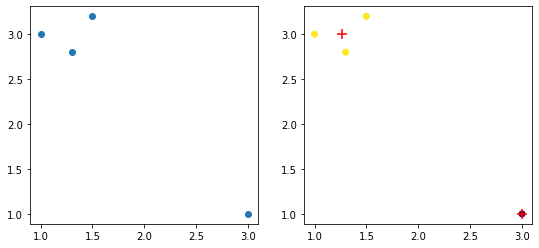

In [5]:
f, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].scatter(X[:, 0], X[:, 1])
axes[1].scatter(X[:, 0], X[:, 1], c=fcm_labels)
axes[1].scatter(fcm_centers[:, 0], fcm_centers[:, 1], marker='+', s=100, c='r')
# plt.savefig('example_result.png')

In [6]:
print(fcm.partition_coefficient)
print(fcm.partition_entropy_coefficient)

0.49291575679953564
0.02894516968380188


### Datasets

| Dataset     | Main Problems of the Set                        | No. Clusters | No. Columns | Column Names | No. Rows
| :---        | :---                                            |:---:         | :---:       | :---:        | :---:
| Hepta       | none, i.e clear defined clusters                |7             | 3           | C1 C2 C3     | 212
| Tetra       | almost touching clusters                        |4             | 3           | C1 C2 C3     | 400
| Chainlink   | linear not separable                            |2             | 3           | C1 C2 C3     | 1000
| Atom        | different variances and linear not separable    |2             | 3           | C1 C2 C3     | 800
| GolfBall    | no cluster at all                               |1             | 3           | C1 C2 C3     | 4002
| Lsun        | different variances and inter cluster distances |3             | 2           | C1 C2        | 400
| EngyTime    | gaussian mixture                                |2             | 2           | C1 C2        | 4096	
| Target      | outlier                                         |6             | 2           | C1 C2        | 770
| TwoDiamonds | cluster border defined by density               |2             | 2           | C1 C2        | 800
| WingNut     | density vs. distance                            |2             | 2           | C1 C2        | 1016	
| ِMySet1     | -                                               |4             |2            |C1 C2        | 33
|MySet2     | -                                                |4             |2           |C1 C2         | 600

In [7]:
def create_dataset(info):
    datasets = []
    n_clusters = []
    labels = []
    
    for name, n_cluster in info: 
        dataset = pd.read_csv('dataset/FCPS/Sets/' + name + '.lrn', sep='\s+').drop('Key', axis=1)
        label = pd.read_csv('dataset/FCPS/Labels/' + name + '.txt', sep='\s+').drop('datapoint', axis=1)
        dataset.name = name
        label.name = name
        datasets.append(dataset)
        n_clusters.append(int(n_cluster))
        labels.append(label)
    return datasets, n_clusters, labels

In [8]:
def visualize_dataset(datasets, projection=None):
    proj = '2d'
    fig = plt.figure(figsize=(26, 5)) if projection==None else plt.figure(figsize=(52, 10))
    
    for i in range(len(datasets)): 
        ax = fig.add_subplot(1, 5, i+1, projection=projection) 
        dataset = datasets[i]
        ax.set_title(dataset.name)

        if len(dataset.columns)==3:
            proj = '3d'
            ax.scatter(dataset['C1'], dataset['C2'], dataset['C3'])   
        else:
            ax.scatter(dataset['C1'], dataset['C2'])
            
#     plt.savefig('dataset '+ proj + '.png')        
    plt.show()

In [9]:
datasets, n_clusters, labels = create_dataset(np.array([['Hepta', 7], ['Tetra', 4], ['Chainlink', 2], ['Atom', 2],
                                                        ['GolfBall', 1], ['Lsun', 3], ['EngyTime', 2],
                                                        ['Target', 6], ['TwoDiamonds', 2], ['WingNut', 2],
                                                        ['MySet1', 4], ['MySet2', 4]]))

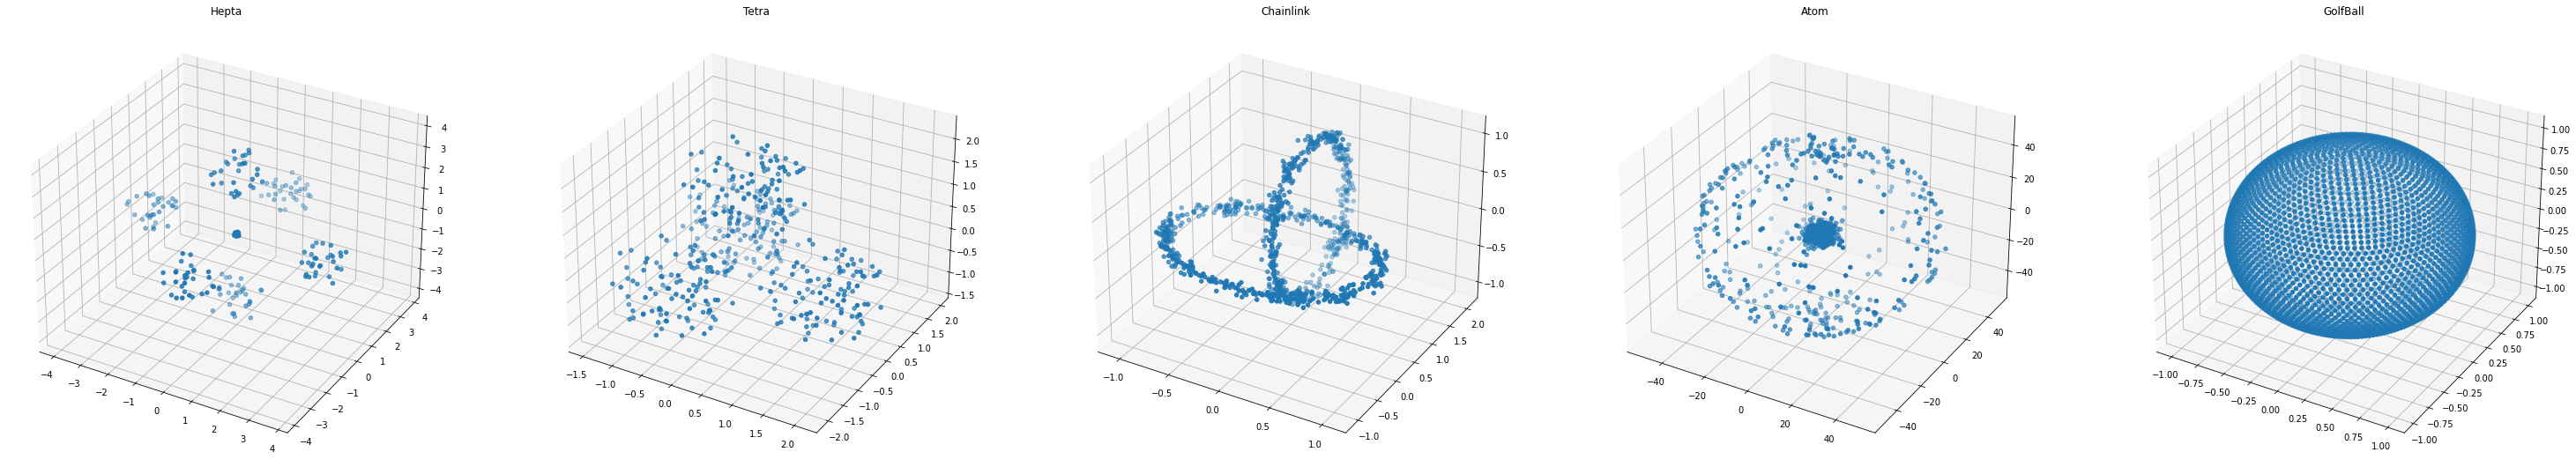

In [10]:
visualize_dataset(datasets[0: 5], projection='3d')

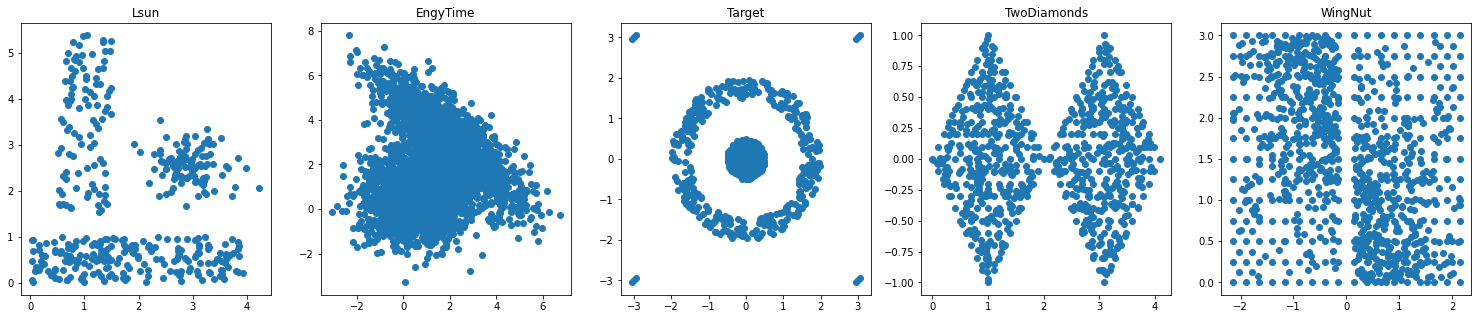

In [11]:
visualize_dataset(datasets[5: -2])

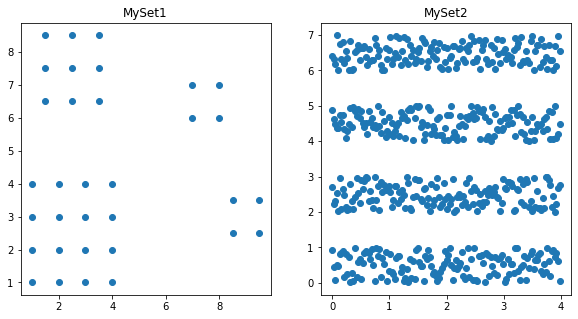

In [12]:
visualize_dataset(datasets[10: ])

### Train

In [13]:
def train_fcm(dataset, n_clusters, m=2, random_state=48):
    start_time = time.time()
    fcm = FCM(n_clusters=n_clusters, m=m, random_state=random_state, error=1e-8) 
    fcm.fit(dataset.to_numpy())
    return fcm, start_time

In [14]:
def visualize_result(dataset, n_cluster, label, predict, projection=None):    
    fig = plt.figure(figsize=(12, 15)) if projection=='3d' else plt.figure(figsize=(10, 5))     
    
    axes = []
    axes.append(fig.add_subplot(1, 2, 1, projection=projection))
    axes.append(fig.add_subplot(1, 2, 2, projection=projection))
    axes[0].set_title(f'Dataset {dataset.name} Real Label')
    axes[1].set_title(f'Dataset {dataset.name} Predicted Label')
    
    if len(dataset.columns) == 3:
        axes[0].scatter(dataset['C1'], dataset['C2'], dataset['C3'], c=label)
        axes[1].scatter(dataset['C1'], dataset['C2'], dataset['C3'], c=predict)          
    else:
        axes[0].scatter(dataset['C1'], dataset['C2'], c=label)
        axes[1].scatter(dataset['C1'], dataset['C2'], c=predict)
#     plt.savefig('test on ' + dataset.name + '.png')
    plt.show()

In [15]:
def log_result(dataset, execution_time, rand_score):
    filename = "FCM Results/"+dataset+".txt"
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    f = open(filename, "a")
    f.write('dataset: ' + dataset + '\n'+
            '--- execution time: '+str(execution_time)+' seconds ---\n'+
            '--- rand index score: '+str(rand_score)+' ---\n\n')
    f.close()

In [19]:
for i in range(len(datasets)):
    dataset = datasets[i]
    n_cluster = n_clusters[i]
    label = labels[i].label.to_numpy()
    fcm, start_time = train_fcm(dataset, n_cluster)
    predict = fcm.predict(dataset.to_numpy())
    r_score = rand_score(label, predict)
    execution_time = time.time() - start_time
#     if i < 5:
#         visualize_result(dataset, n_cluster, label, predict, projection='3d')
#     else:
#         visualize_result(dataset, n_cluster, label, predict)
    if i > 9:
        log_result(dataset.name, execution_time, r_score)